# **Multi-Class Classification (Excluding Text Features)**

-------
### Imports

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, precision_score

-------
## Reading in the Listings Dataset

In [170]:
listings = pd.read_csv('../data/listings_cleaned.csv')

In [171]:
listings.head(2)

,id,last_scraped,name,description,host_id,host_name,host_since,host_response_time,host_response_rate,host_is_superhost,...,reviews_per_month,city,state,zip_codes,bathrooms,bathrooms_shared,amenities_count,host_verifications_count,private_listing,rating_target
0,3781,2021-09-19,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,4804,Frank,2008-12-03,3,100.0,0,...,0.29,Boston,Massachusetts,2128,1.0,0,31,3,1,3
1,5506,2021-09-19,** Private! Minutes to center!**,"Private guest room with private bath, You do n...",8229,Terry,2009-02-19,3,100.0,1,...,0.90,Boston,Massachusetts,2119,1.0,0,30,4,1,2


------
# **Modeling**

In [172]:
# building a simple model to gauge performance
features = ['amenities_count', 'host_response_time', 
            'host_response_rate', 'host_has_profile_pic','accommodates','license',
            'reviews_per_month', 'host_verifications_count'] # intentionally not including price, didn't appear to be strong predictor of rating based on EDA

# define X and y
X = listings[features]
y = listings['rating_target']

In [173]:
# establishing the baseline accuracy
print(y.value_counts())
print('*'*45)
print(y.value_counts(normalize=True))
print('*'*45)

print(f'Baseline Accuracy: {round(pd.Series(y.value_counts(normalize=True))[2]*100, 2)}%')


2    2713
1    2681
3    2647
4    2623
Name: rating_target, dtype: int64
*********************************************
2    0.254407
1    0.251407
3    0.248218
4    0.245968
Name: rating_target, dtype: float64
*********************************************
Baseline Accuracy: 25.44%


In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Scale and fit Basic KNN

In [175]:
ss= StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [176]:
# instantiate and fit KNNeighbors model with defaults
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)

print(f'training accuracy: {knn.score(X_train_sc, y_train)}')
print(f'test accuracy: {knn.score(X_test_sc, y_test)}')

training accuracy: 0.6415353838459615
test accuracy: 0.45723930982745686


## Fit basic Multinomial Logistic Regression

In [177]:
log = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log.fit(X_train, y_train)

print(f'training accuracy: {log.score(X_train, y_train)}')
print(f'test accuracy: {log.score(X_test, y_test)}')

training accuracy: 0.3582145536384096
test accuracy: 0.3555888972243061


/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [178]:
# see if standardizing improves performance
log = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log.fit(X_train_sc, y_train)

print(f'training accuracy: {log.score(X_train_sc, y_train)}')
print(f'test accuracy: {log.score(X_test_sc, y_test)}')

training accuracy: 0.3704676169042261
test accuracy: 0.37209302325581395


## Fit basic Multinomial Naive Bayes

In [179]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

print(f'training accuracy: {nb.score(X_train, y_train)}')
print(f'test accuracy: {nb.score(X_test, y_test)}')

training accuracy: 0.34833708427106774
test accuracy: 0.3537134283570893


Poor performance on the basic features selected. KNN performed best in this scenario, though it's significantly overfit.

-------

## Attempt to throw more features at the models

In [180]:
listings.dtypes

id                                                int64
last_scraped                                     object
name                                             object
description                                      object
host_id                                           int64
host_name                                        object
host_since                                       object
host_response_time                                int64
host_response_rate                              float64
host_is_superhost                                 int64
abnb_host_listings_count                        float64
host_verifications                               object
host_has_profile_pic                              int64
host_identity_verified                            int64
neighborhood                                     object
latitude                                        float64
longitude                                       float64
property_type                                   

In [181]:
# preprocessing to make sure desired feature columns are numerical

# dummify neighborhood, property type, and room type columns
print(listings.shape)
listings_dummy = pd.get_dummies(listings, columns = ['neighborhood','property_type','room_type'], drop_first = True)


listings_dummy.shape

(10664, 55)


(10664, 125)

In [182]:
features = [col for col in listings_dummy._get_numeric_data().columns]

# define X and y
X = listings_dummy[features]
y = listings_dummy['rating_target']

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [184]:
print(X_train.shape)
print(X_test.shape)

(7998, 113)
(2666, 113)


## Scale and fit KNN

In [185]:
ss= StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [186]:
# instantiate and fit KNNeighbors model with defaults
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)

print(f'training accuracy: {knn.score(X_train_sc, y_train)}')
print(f'test accuracy: {knn.score(X_test_sc, y_test)}')

training accuracy: 0.7868217054263565
test accuracy: 0.6342835708927231


## Fit Multinomial Logistic Regression

In [187]:
# see if standardizing improves performance
log = LogisticRegression(max_iter = 200, multi_class='multinomial', solver='lbfgs')
log.fit(X_train_sc, y_train)

print(f'training accuracy: {log.score(X_train_sc, y_train)}')
print(f'test accuracy: {log.score(X_test_sc, y_test)}')

training accuracy: 1.0
test accuracy: 0.9996249062265566


In [188]:
y_preds = log.predict(X_test_sc)

In [189]:
print(precision_score(y_test, y_preds, average='micro'))
precision_score(y_test, y_preds, average='macro')

0.9996249062265566


0.9996274217585693

/Users/petermurphy/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


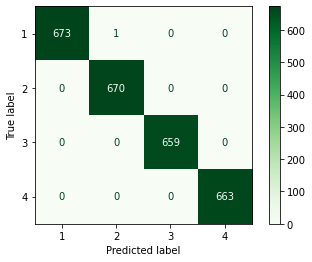

In [193]:
plot_confusion_matrix(log, X_test_sc, y_test, cmap = 'Greens');

------

# Model Evaluation

In [ ]:
Regularization

In [ ]:
PCA

In [ ]:
Transfer Learning with Clustering

Precision if balanced, f1 if unbalanced classes

ROC Curve for analysis

In [ ]:
pd.Series(pipe.feature_importances_, index = good_cols)

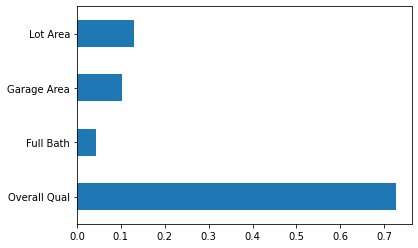

In [48]:
pd.Series(pipe.feature_importances_, index = good_cols).plot(kind = 'barh');